<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Load-packages" data-toc-modified-id="Load-packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load packages</a></span></li><li><span><a href="#Initialization" data-toc-modified-id="Initialization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#Load-power-spectra" data-toc-modified-id="Load-power-spectra-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load power spectra</a></span></li><li><span><a href="#Flat-sky-configuration" data-toc-modified-id="Flat-sky-configuration-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Flat-sky configuration</a></span></li><li><span><a href="#Generate-simulated-data" data-toc-modified-id="Generate-simulated-data-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generate simulated data</a></span></li></ul></li><li><span><a href="#The-algorithm" data-toc-modified-id="The-algorithm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The algorithm</a></span><ul class="toc-item"><li><span><a href="#Inputs" data-toc-modified-id="Inputs-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Inputs</a></span></li><li><span><a href="#Run-it!" data-toc-modified-id="Run-it!-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Run it!</a></span></li></ul></li><li><span><a href="#Examine-results" data-toc-modified-id="Examine-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Examine results</a></span></li></ul></div>

# Introduction

Maps of the gravitationally lensed cosmic microwave background (CMB) offer a wealth of information on fundamental physics. Extracting this information optimally (in the statistical sense) is a major goal of current and future CMB efforts. The inferred maps of the CMB gravitational lensing potential, $\phi(x)$, can be used to used to constrain the late-time evolution and structure grown of the universe, leading to, for example, better constraints on neutrino masses. The "delensed" maps of the CMB temperature and E&B-mode polarization, $f(x)\equiv[T(x), E(x), B(x)]$, can be used to hunt for signatures of inflation; any non-zero $B(x)$ would likely consistute the first ever detection of gravitational waves from inflation. 

In our recent paper, [Millea, Anderes, & Wandelt (2017)](https://arxiv.org/abs/1708.06753), we developed the first algorithm which is able to simultaneousy reconstruct both $\phi(x)$ and $f(x)$ from noisy CMB data, and which can lead to such optimal constraints.

Owing to the linearity of the problem, the exact joint Bayesian posterior of these quantities, 

\begin{align}
\mathcal{P}\big(f(x), \phi(x) \,\big|\,d(x)\big),
\end{align}

where $d(x)$ is the data, can be analytically expressed and calculated. Our algorithm maximizes this probability function via a "coordinate descent", meaning we take a gradient step with respect to $\phi$, then a gradient step with respect to $f$, then repeat. 

This notebook generates some simulated data for a 128x128 pixel patch of sky, then runs this coordinate descent for 10 steps. The whole analysis takes one to a few minutes depending on the computer. In the end, one can verify visually and by comparing power spectra the fidelity of the reconstructed $\phi(x)$ and $f(x)$ with respect to the simulated input truths. 

# Load packages

In [1]:
using Revise

In [2]:
using CMBLensing
using CMBLensing: cache, δlnΠᶠ_δfϕ, get_ℓ⁴Cℓ, LP
using JLD
using PyPlot
using Optim: optimize
using Base.Iterators: repeated

INFO: Recompiling stale cache file /home/marius/.julia/lib/v0.6/CMBLensing.ji for module CMBLensing.


# Initialization

## Load power spectra

Load some power-spectra we've precomputed with CLASS (these have $r=0.05$),

In [3]:
Cℓ = load("fidcls_r05.jld","Cℓ")
Cℓf,Cℓf̃ = Cℓ[:f],Cℓ[:f̃];

Chose the noise power-spectra we are assuming,

In [4]:
Cℓn = noisecls(1,beamFWHM=3,ℓknee=100);

Plot these up for reference,

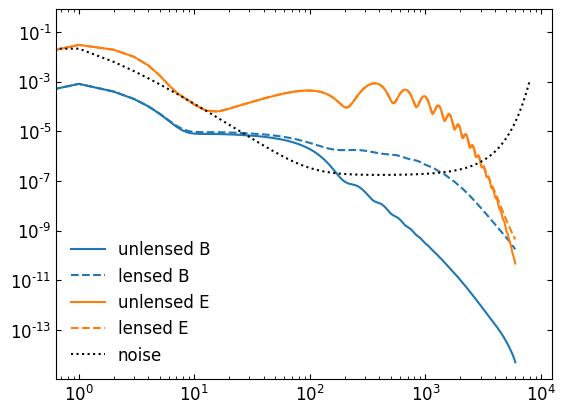

In [5]:
loglog(Cℓf[:BB],c="C0")
loglog(Cℓf̃[:BB],"--",c="C0")
loglog(Cℓf[:EE],c="C1")
loglog(Cℓf̃[:EE],"--",c="C1")
loglog(Cℓn[:BB],"k:")
legend(["unlensed B","lensed B","unlensed E","lensed E","noise"]);

## Flat-sky configuration

First, we set up the size and pixelization of our flat-sky maps,

In [6]:
Θpix = 3 # arcmin pixels
nside = 128 # pixels per side

T = Float32
P = Flat{Θpix,nside};

This converts the $C_\ell$ angular power spectra from above into flat-sky 2D covariances,

In [7]:
SS,ks =(S0,S2),(:TT,:EE,:BB,:TE)
Cn = Cℓ_to_cov(T,P,SS..., Cℓn[:ℓ], (Cℓn[k] for k=ks)...)
Cf = Cℓ_to_cov(T,P,SS..., Cℓf[:ℓ], (Cℓf[k] for k=ks)...)
Cf̃ = Cℓ_to_cov(T,P,SS..., Cℓf[:ℓ], (Cℓf̃[k] for k=ks)...)
Cϕ = Cℓ_to_cov(T,P,S0,    Cℓf[:ℓ], Cℓf[:ϕϕ]);

## Generate simulated data

For reproducibility, we'll set the random seed,

In [8]:
srand(2);

Lets simulate a $\phi$ map which will be the "truth",

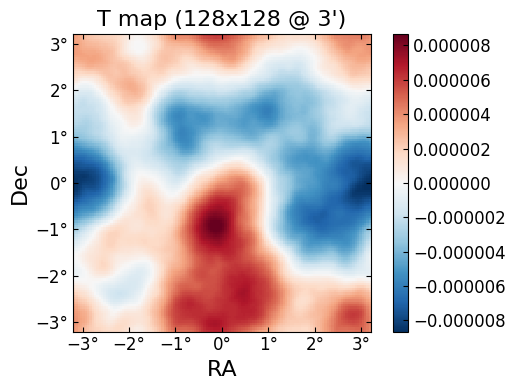

In [9]:
ϕ = simulate(Cϕ)
plot(ϕ);

And a "true" unlensed field, $f$,

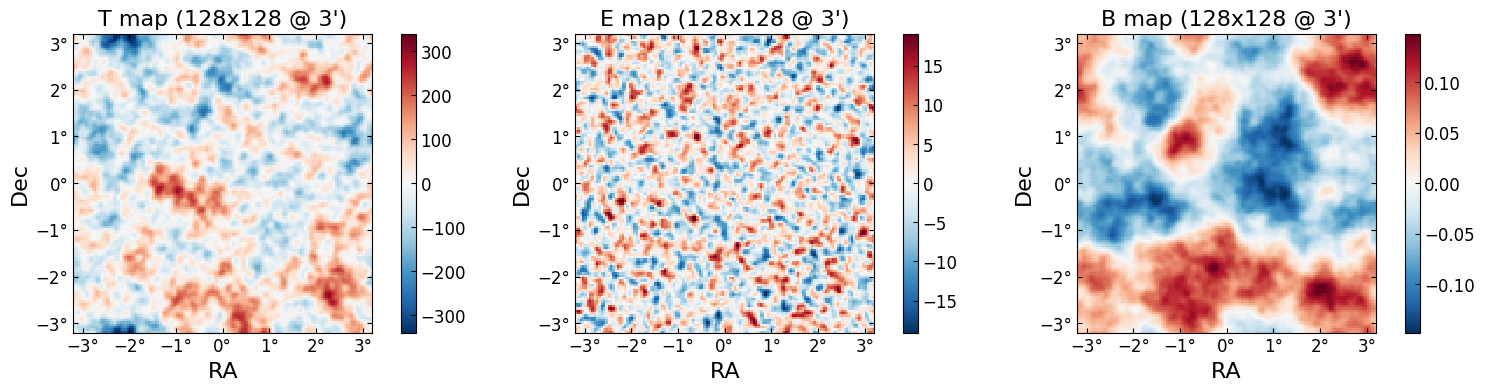

In [10]:
f = simulate(Cf)
plot(f);

We can compute the "true" lensed field,

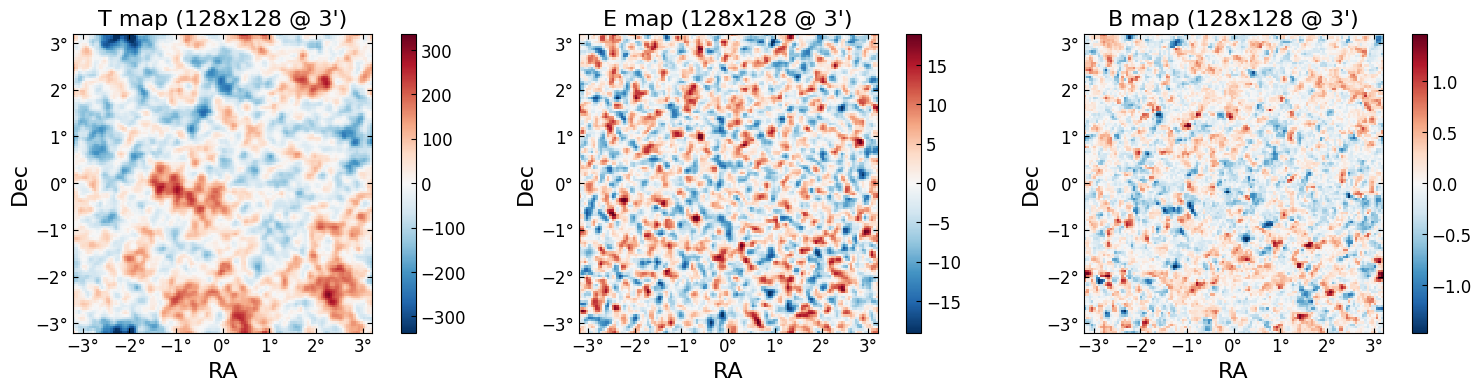

In [11]:
L = LenseFlow
f̃ = L(ϕ)*f
plot(f̃);

Our simulated data is then the lensed field $\tilde f$, with a sample of the noise,

In [12]:
# data mask
M = LP(3000);

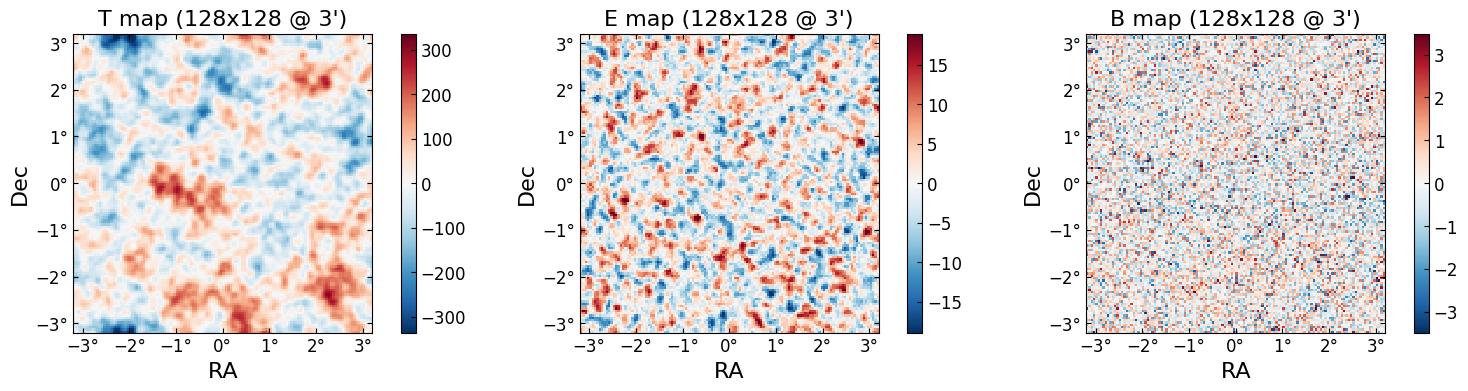

In [13]:
d = M*f̃ + simulate(Cn)
plot(d);

# The algorithm

## Inputs

The algorithm needs as input the cooling weights, which are computed from some simulations. We've precomputed these for this particular run. The weights depend on the mask, beam, noise levels, pixelization, the number of steps you intend to run the algorithm, and loosely on a fiducial cosmology. Using the "wrong" weights means only sub-optimal convergence speed, not errors in the final answer. 

In [14]:
wℓᵢ = [0; [wℓ[round.(Int,Cℓf[:ℓ])] for wℓ in load("weights_128example.jld","wℓ")]; 1];

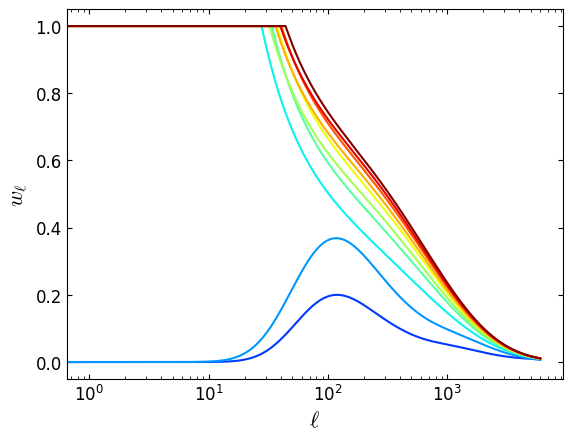

In [15]:
for (i,wℓ) in enumerate(wℓᵢ)
    semilogx(wℓ,c=get_cmap("jet",length(wℓᵢ))(i))
end
xlabel(raw"$\ell$")
ylabel(raw"$w_\ell$");

The starting point for the algorithm is simply $\phi=0$

In [16]:
ϕcur = 0ϕ;

You don't need to specify starting points for $f$ or $\tilde f$ 

In [17]:
fcur, f̃cur = nothing, nothing;

## Run it!

In [18]:
tr = []

0-element Array{Any,1}

In [19]:
global χ² # this will track the χ² w.r.t. the cooling covariance of the current step

@time for (i,wℓ) in enumerate(wℓᵢ)

    # compute the cooling covariance
    Ĉf = Cℓ_to_cov(T,P,SS..., Cℓf[:ℓ], ((@. sign(Cℓf̃[k])*abs(Cℓf̃[k])^(1-wℓ)*abs(Cℓf[k])^wℓ) for k=ks)...)
    
    # for convenience below, the "dataset" holds data, covariances, and mask
    ds = DataSet(d, Cn, Ĉf, Cϕ, M, 1)
    
    # ----------------------------
    # the f step (a Wiener filter)
    # ----------------------------
    
    let L = (i==1 ? IdentityOp : cache(L(ϕcur)))
        fcur = lensing_wiener_filter(ds, L, tol=1e-1)
        f̃cur = L*fcur
    end
    
    # ----------
    # the ϕ step
    # ----------
    
    if i!=endof(wℓᵢ) # ϕ step is skipped for the last iteration
        
        # compute gradient
        ϕnew = Cϕ*(δlnΠᶠ_δfϕ(fcur,ϕcur,ds) * δfϕ_δf̃ϕ(L(ϕcur),fcur,f̃cur))[2]
        
        # do linesearch
        res = optimize(α->(-lnP(1,f̃cur,(1-α)*ϕcur+α*ϕnew,ds,L)), T(0), T(0.1), abs_tol=1e-2)
        α = res.minimizer
        χ² = 2res.minimum
        
        # update current ϕ
        ϕcur = (1-α)*ϕcur+α*ϕnew
    else
        χ² = -2lnP(1,f̃cur,ϕcur,ds,L) # final iteration just compute the final likelihood 
    end
    push!(tr,ϕcur)
    @show i, χ²
        
end

(i, χ²) = (1, 48070.87f0)
(i, χ²) = (2, 48137.91f0)
(i, χ²) = (3, 48095.277f0)
(i, χ²) = (4, 48118.895f0)
(i, χ²) = (5, 48132.406f0)
(i, χ²) = (6, 48093.582f0)
(i, χ²) = (7, 48063.54f0)
(i, χ²) = (8, 48025.48f0)
(i, χ²) = (9, 48004.68f0)
(i, χ²) = (10, 47979.816f0)
(i, χ²) = (11, 47935.12f0)
(i, χ²) = (12, 49437.46f0)
 51.314298 seconds (19.42 M allocations: 35.566 GiB, 17.34% gc time)


# Examine results

The expected value of the final best-fit $\chi^2 (i.e. -2\log \mathcal{P}$) is given by the number of unmasked degrees of freedom in the data (remember we applied an $\ell<3000$ data mask so this number is slightly lower than the the total number of pixels in IQU which would be  $3\cdot128^2$)

In [20]:
dof = 3nside^2

49152

Here's how far away our final $\chi^2$ is from this expectation, in units of $\sigma$,

In [21]:
(χ² - dof)/sqrt(2dof)

0.9104604666295832

Here's the best-fit $\phi$ (left) relative to the truth (right),

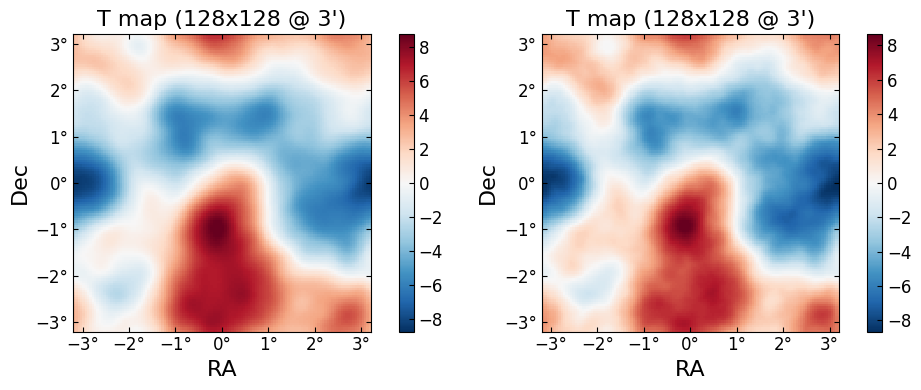

In [22]:
plot(10^6*[ϕcur,ϕ]');

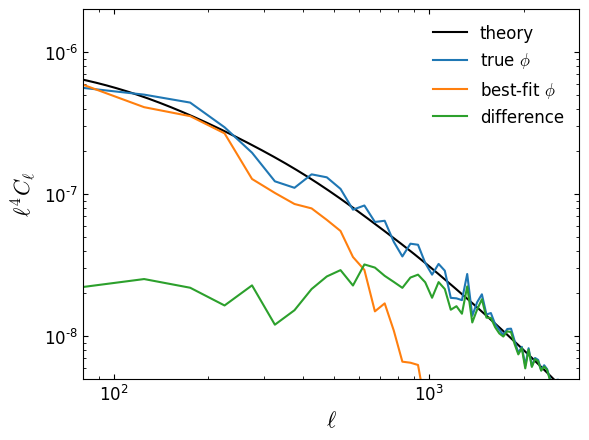

In [23]:
loglog(Cℓf[:ℓ],(@. Cℓf[:ℓ]^4 * Cℓf[:ϕϕ]),"k")
loglog(get_ℓ⁴Cℓ(ϕ)...)
loglog(get_ℓ⁴Cℓ(ϕcur)...)
loglog(get_ℓ⁴Cℓ(ϕcur-ϕ)...)
xlim(80,3000)
ylim(5e-9,2e-6)
legend(["theory",raw"true $\phi$", raw"best-fit $\phi$", "difference"])
xlabel(raw"$\ell$")
ylabel(raw"$\ell^4 C_\ell$");

The best-fit unlensed field (bottom row) relative to truth (top row),

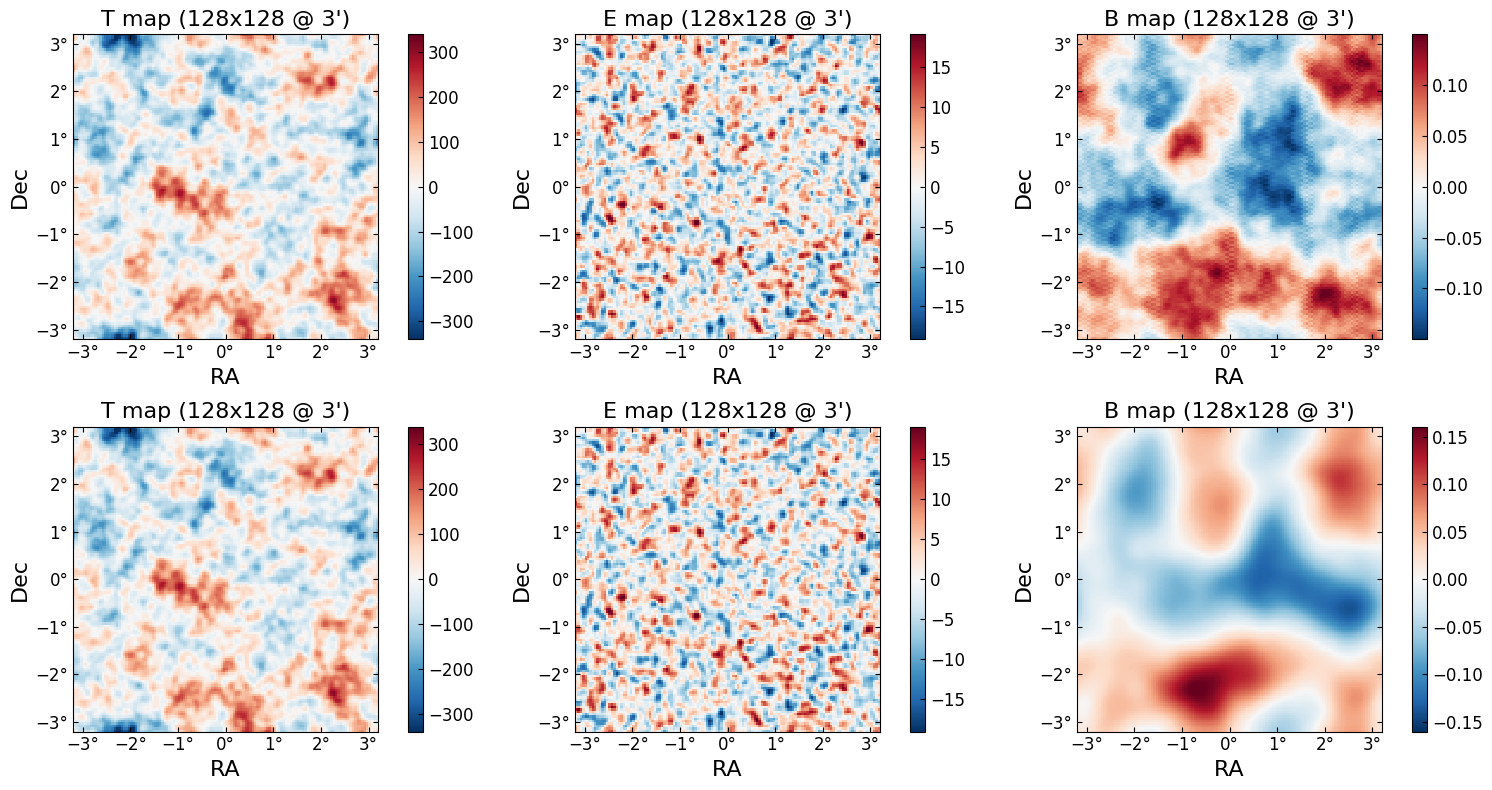

In [24]:
plot([f,fcur]);

The best-fit lensed field (bottom row) relative to truth (top row),

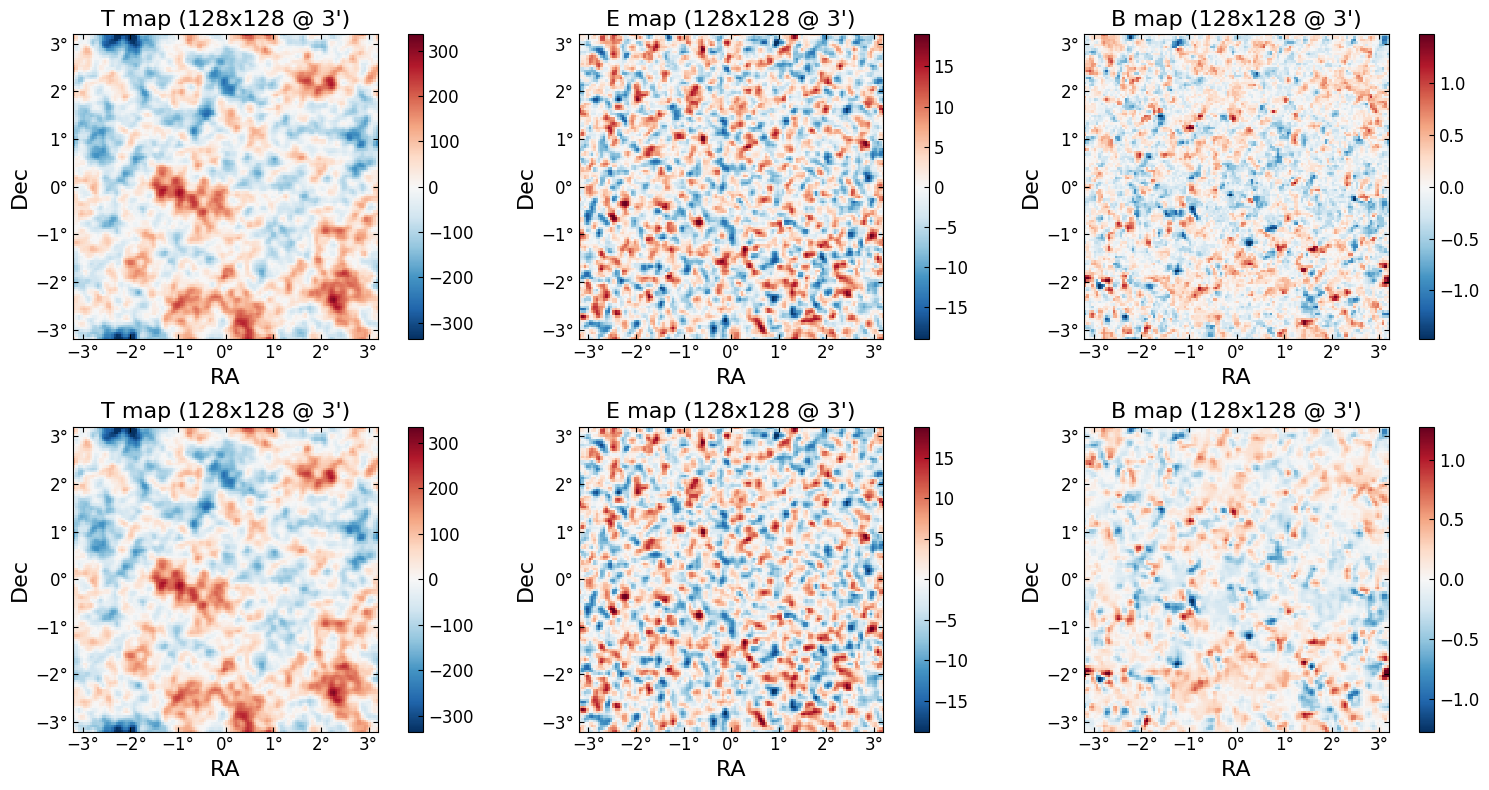

In [25]:
plot([f̃,f̃cur]);